In [1]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=99eab717ce17207d9516b43e9307a71919e2a7371b0f151793a8622cf710d849
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
#from keras.utils import np_utils
#from keras.utils.vis_utils import plot_model


from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



In [3]:
def DataLoader(FilePath,FileName):
  DataFrame = pd.read_csv(path+FileName)
  DataFrame=DataFrame.sample(len(DataFrame))

  if 'target' in DataFrame.columns:
    labels=DataFrame['target']
    DataFrame.drop(['target','fbs'],inplace=True,axis=1)
    return DataFrame,labels

In [4]:
def outliers_removal(df):
  for col in df.columns:
    q1,meadian,q3=np.percentile(df.loc[:,col],[25,50,75])
    range=q3-q1
    min=q1-(range*1.5)
    max=q3+(range*1.5)
    df.loc[df[col] < min,col] = meadian
    df.loc[df[col] > max,col] = meadian

  return df


In [5]:
def DataScaler(data):
  file_path = "/content/drive/MyDrive/Colab Notebooks/heart disease models/"
  scaler=StandardScaler()
  scaler.fit(data)

  with open(file_path + 'scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

  ScaledData=pd.DataFrame(scaler.transform(data),columns=data.columns)
  return ScaledData


In [6]:
path="/content/drive/MyDrive/Colab Notebooks/heart disease models/"
FileName="heart.csv"

df,labels=DataLoader(path,FileName)
df=outliers_removal(df)
df=DataScaler(df)

x_train, x_test, y_train, y_test = train_test_split(df, labels,test_size=0.2)

In [7]:
test,l=DataLoader(path,FileName)

In [8]:
test.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal
86,68,1,2,118,277,1,151,0,1.0,2,1,3
90,48,1,2,124,255,1,175,0,0.0,2,2,2
85,67,0,2,115,564,0,160,0,1.6,1,0,3
48,53,0,2,128,216,0,115,0,0.0,2,0,0
189,41,1,0,110,172,0,158,0,0.0,2,0,3


<Axes: >

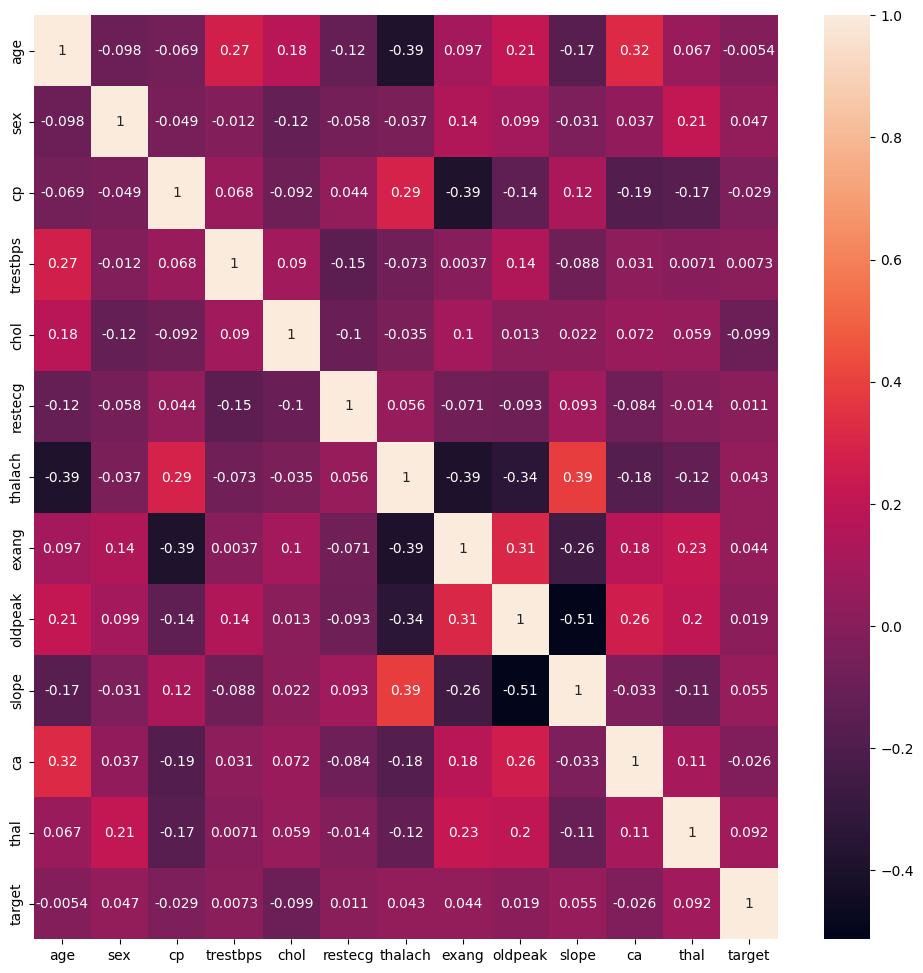

In [9]:
plt.figure(figsize=(12,12))
FullData=df
FullData["target"]=labels
sns.heatmap(data=FullData.corr(),annot=True)

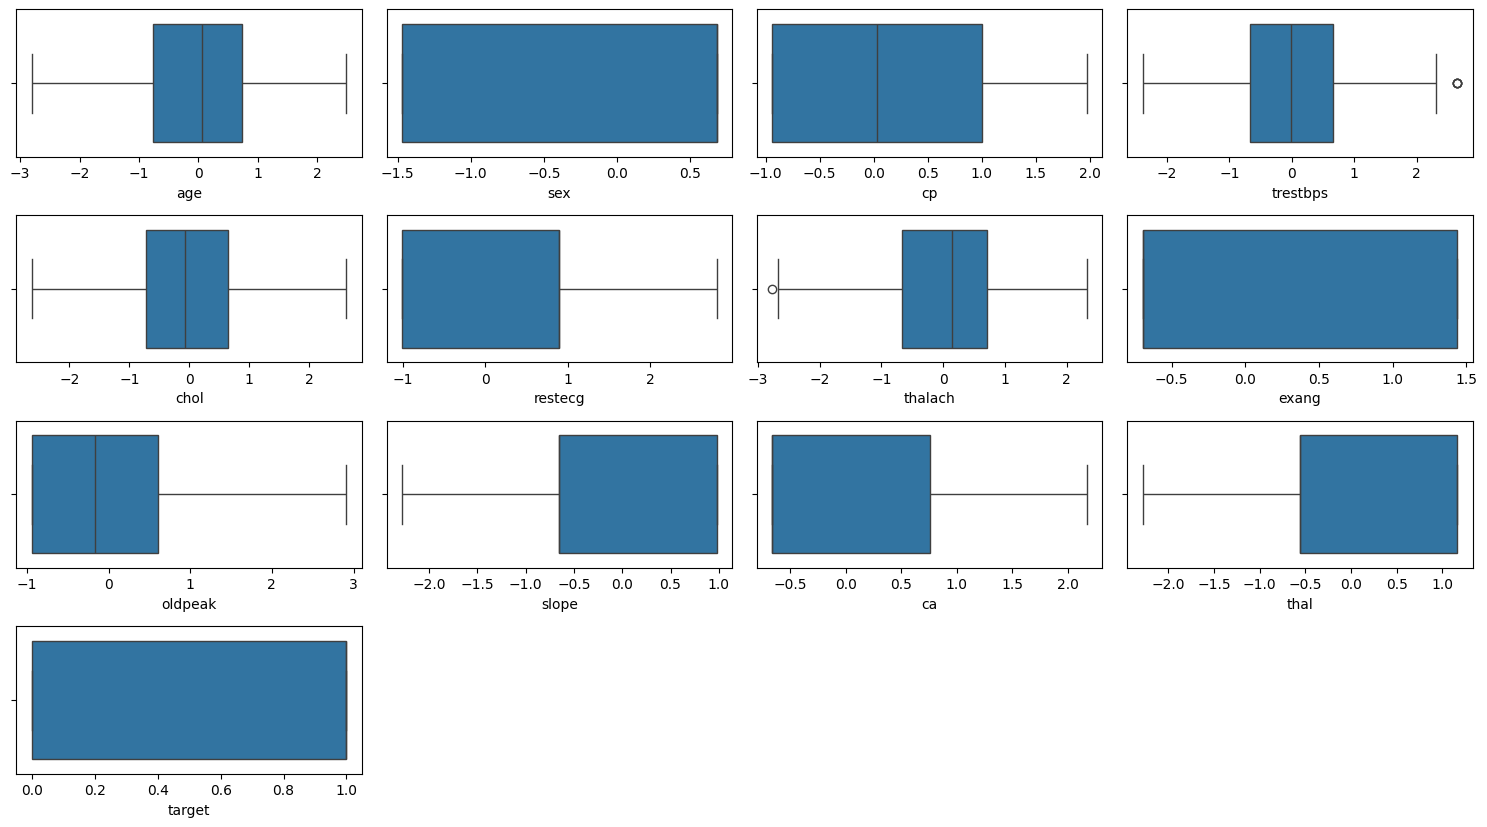

In [10]:
fig = plt.figure(figsize=(15,10))
for i ,col in enumerate (df.columns,1):
    ax=fig.add_subplot(5,4,i)
    sns.boxplot(x=df[col],ax=ax)
plt.tight_layout()

In [11]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(11 , activation="relu"))

model.add(keras.layers.Dense(20 , activation="relu"))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(16 , activation="relu"))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(8 , activation="relu"))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(1 , activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None,12))

In [12]:
def build_network(input_size):
  model = keras.models.Sequential()

  model.add(keras.layers.Dense(input_size , activation="relu"))
  model.add(keras.layers.Dropout(0.25))

  model.add(keras.layers.Dense(20 , activation="relu"))
  model.add(keras.layers.Dropout(0.25))

  model.add(keras.layers.Dense(16 , activation="relu"))
  model.add(keras.layers.Dropout(0.25))

  model.add(keras.layers.Dense(8 , activation="relu"))
  model.add(keras.layers.Dropout(0.25))

  model.add(keras.layers.Dense(1 , activation="sigmoid"))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


In [13]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('target' , axis = 1), labels,test_size=0.2)

In [14]:
from sklearn.decomposition import PCA
from keras.callbacks import ModelCheckpoint
def dimensionality_selection(epochs, dataset,labels,minimum,maximum):
  accuracies={}

  for n in range (minimum,maximum+1):
    pca = PCA(n_components=n)
    reduced_data=pca.fit_transform(dataset)
    print(dataset.shape)

    filepath=path+'ann_models/'
    model=build_network(n)
    model_checkpoint=ModelCheckpoint(
        filepath=filepath,
        monitor='accuracy',
        mode='max',
        save_best_only=True
    )

    history=model.fit(reduced_data,labels,epochs=epochs,validation_split=0.1,callbacks=[model_checkpoint])
    history=pd.DataFrame(history.history)
    print(history.info())
    accuracies[n]=(history)
    modelName="model"+str(n)+".pb"

    filename = filepath+modelName
    joblib.dump(model, filename)

    with open(filepath + f'pca_{n}.pkl', 'wb') as pca_file:
        pickle.dump(pca, pca_file)
  return accuracies,model


In [15]:
x_train.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal
67,-1.143291,-1.468418,1.002577,-0.800542,-0.022250,0.898962,-0.040931,-0.696631,-0.646189,-0.649113,0.756398,-0.561341
127,-1.253580,-1.468418,-0.938515,0.126286,2.195112,-1.005832,-0.620880,1.435481,1.951586,-0.649113,-0.658347,1.156703
33,-0.260980,0.681005,-0.938515,-0.337128,-0.694178,0.898962,0.806688,-0.696631,0.027308,0.976352,2.171144,1.156703
255,-0.702136,0.681005,0.032031,-0.006118,0.044943,-1.005832,1.342026,-0.696631,-0.742403,-0.649113,-0.658347,-0.561341
109,-0.040403,0.681005,1.002577,1.317922,-0.246226,-1.005832,0.672854,-0.696631,0.604592,0.976352,-0.658347,1.156703


In [16]:
lst,mod=dimensionality_selection(200,x_train,y_train,8,12)

(242, 12)
Epoch 1/200
7/7 [==============================] - 15s 1s/step - loss: 0.7122 - accuracy: 0.4931 - val_loss: 0.6712 - val_accuracy: 0.6000
Epoch 2/200
7/7 [==============================] - 2s 405ms/step - loss: 0.6936 - accuracy: 0.5484 - val_loss: 0.6623 - val_accuracy: 0.6800
Epoch 3/200
7/7 [==============================] - 2s 385ms/step - loss: 0.6575 - accuracy: 0.5945 - val_loss: 0.6546 - val_accuracy: 0.6400
Epoch 4/200
7/7 [==============================] - 0s 26ms/step - loss: 0.6616 - accuracy: 0.5945 - val_loss: 0.6456 - val_accuracy: 0.6800
Epoch 5/200
7/7 [==============================] - 2s 382ms/step - loss: 0.6848 - accuracy: 0.6129 - val_loss: 0.6399 - val_accuracy: 0.7200
Epoch 6/200
7/7 [==============================] - 0s 31ms/step - loss: 0.6876 - accuracy: 0.5300 - val_loss: 0.6334 - val_accuracy: 0.7200
Epoch 7/200
7/7 [==============================] - 0s 28ms/step - loss: 0.6727 - accuracy: 0.5991 - val_loss: 0.6280 - val_accuracy: 0.7600
Epoch 8/

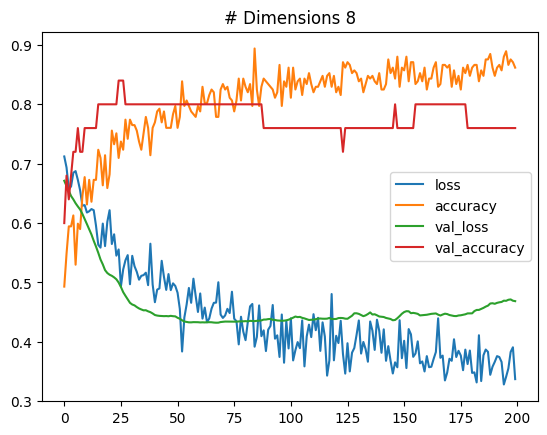

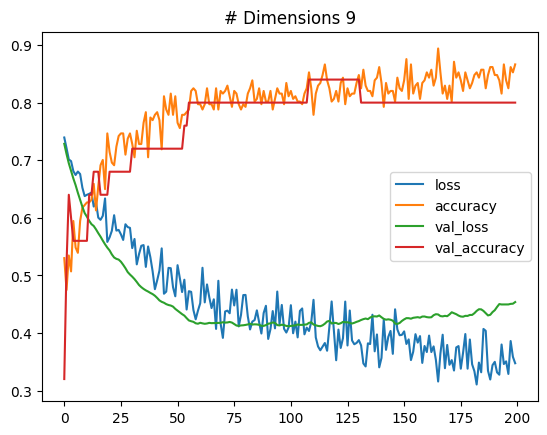

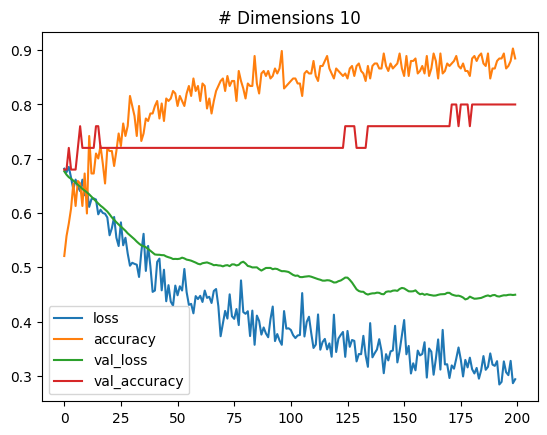

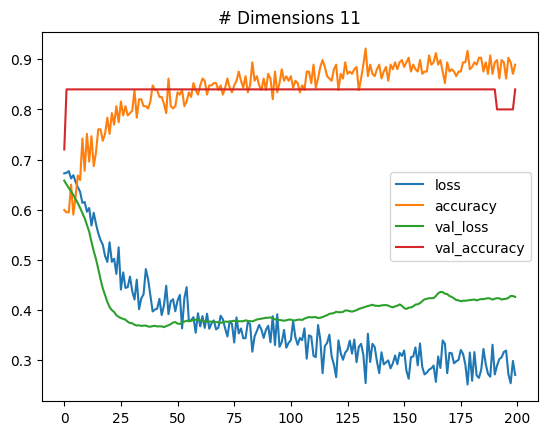

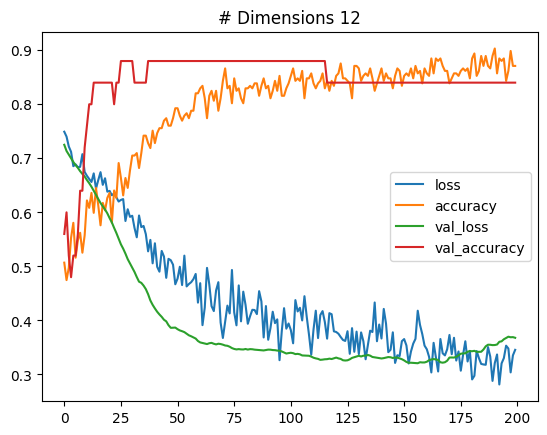

In [17]:
matrices={}
for i in lst.keys():
  matrices[i]=[max(lst[i]['accuracy']),max(lst[i]['val_accuracy']),min(lst[i]['loss']),min(lst[i]['val_loss'])]
  lst[i].plot(title=f"# Dimensions {i}")